# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv')

#посмотрим как выглядит таблица

print(data.head()) 

  total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0  20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...                                                                                                                                                                                                                                                                  
1  7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...                                                                                                                                                                                                                                                                  
2  10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...               

In [3]:
#разделим таблицу по столбцам

data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

In [4]:
#ознакомимся с общей информацией

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Из полученной информации видно:
1. в таблице есть пропущенные значения
2. некоторые типы данных не соответствуют и их нужно изменить

### Предобработка данных

#### Заполнение пропусков:
**'locality_name'**

Прежде всего, есть пропуски в столбце 'locality_name'. Это один из важнейших критериев при группировке и поиске зависимости цены. Так как количество пропусков составляет только 0,2% (23650/23699-1), принято решение эти строки удалить. 

In [5]:
data = data.dropna(subset=['locality_name'])
data.info() #проверка - должно быть 23650 строк итого

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               12137 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**'balcony'**

В столбце 'balcony' пропуски связаны, скорее всего, с незаполнением данных, так как балкона нет.

Заменим в столбце значения NaN на 0.

In [6]:
data['balcony'] = data['balcony'].fillna(0)

**'is_apartment'**

Во-первых, здесь неправильный тип данных. Чтобы понять природу пропусков, нужно посмотреть уникальные значения

In [7]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

То есть, если указано True, то объект является апартаментами, если False, то нет. Скорее всего, ситуация такая же как с балконами - данные не заполнены, так как объект не является апартаментами. Заменим Nan на False

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(False)

**'ceiling_height'**

Данный параметр заполнить возможно. Для этого посмотрим распределение по параметру.

In [9]:
data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Из данных видно, что медиана и среднее сильно не отличаются. Среднее выше из-за аномальных значений, с которыми будем разбираться далее. Поэтому правильней будет использовать медиану. Кроме этого ее значение соответствует нормальной высоте потолков в квартирах и будет логично использовать данное значение. Однако, так как пропусков в данном столбце почти 50%, заполнение их может исказить картину распределения. Далее приводим код, который заполнит пропуски по медиане. При презентации данного проекта можно обсудить этот вопрос с рабочей группой и при необходимости заполнить.

In [10]:
#data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())

Пропуски в прочих столбцах оставим без изменений, так как по ним нельзя предложить логичную замену. Пропуски в столбцах living_area и kitchen_area могут быть связаны с отсутствием данных у продавца (незнанием). Пропуски в столбцах с картографическими данными, которые были загружены дополнительно, скорее всего свзяаны с тем, что у объекта не был указан точный адрес, поэтому данных о расстояниях до отдельных объектов нет.

#### Изменение типов данных:

Еще раз выведем общую информацию, чтобы увидеть типы данных.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Отметим, что после заполнения пропусков в 'is_apartment' тип данных изменился на bool. Итого столбцов с типом данных 'bool' - 3, как заявлено в описании проекта.

float - заменим в столбце 'balcony' на int, так как в этом столбце могут быть указаны только целые числа. 

int - все в порядке

object - необходимо изменить в 'first_day_exposition' на тип данных datetime.

In [12]:
data['balcony'] = data['balcony'].astype('int32')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

data.head() #посмотрим на первые 5 строк обновленной data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Дубликаты:

In [13]:
#явные дубликаты

data.duplicated().sum()

0

Неявные дубликаты могут встретиться только в столбце 'locality_name'. Выведем уникальные значения

In [14]:
#сначала посмотри сколько таких уникальных значений, чтобы дальше отслеживать изменения
data['locality_name'].nunique()

364

In [15]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В названиях встречаются буквы "е" и "ё", заменим их в первую очередь.

In [16]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

#посмотрим сколько ушло дублиатов

data['locality_name'].nunique() #34 значения ушло

330

Теперь заменим ряд названий. 

Здесь следует ометить, что поселок и поселок городского типа специально не объединяются, так как ПГТ имеет ряд преимуществ в части инфраструктуры над поселком, поэтому это может влиять на цену.

Также стоит отметить, что есть ряд неявных дубликатов с одинаковыми названиями, но разными наименованиями населенных пунктов. Например, коттеджный поселок Лесное и поселок Лесное. Это разные населенные пункты (проверено в интернете). Или, к примеру, существует и поселок Рябино и ПГТ Рябино - это тоже 2 разных населенных пункта.

In [17]:
old_name = ['городской поселок','поселок при железнодорожной станции',
            'садоводческое некоммерческое товарищество']
new_name = ['поселок городского типа','поселок станции','садовое товарищество']

data['locality_name'] = data['locality_name'].replace(old_name,new_name,regex=True)

sorted(data['locality_name'].unique()) #проверим новый список

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалево',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'деревня Агалатово',
 'деревня Аро',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Белогорка',
 'деревня Большая Вруда',
 'деревня Большая Пустомержа',
 'деревня Большие Колпаны',
 'деревня Большое Рейзино',
 'деревня Большой Сабск',
 'деревня Бор',
 'деревня Борисова Грива',
 'деревня Ваганово',
 'деревня Вартемяги',
 'деревня Вахнова Кара',
 'деревня Выскатка',
 'деревня Гарболово',
 'деревня Глинка',
 '

#### Аномальные значения:

Для начала построим гистограммы, чтобы ознакомиться подробнее с данными

In [18]:
import matplotlib.pyplot as plt

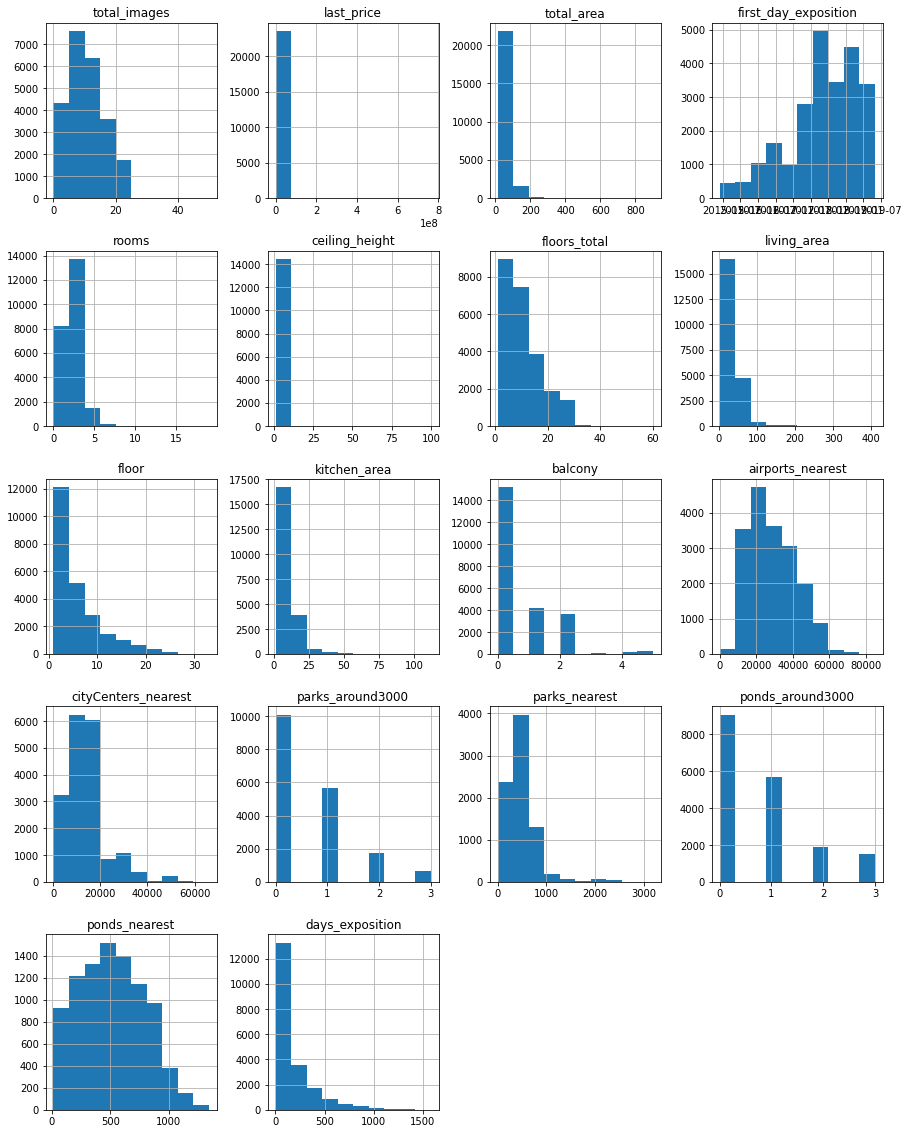

In [19]:
data.hist(figsize=(15, 20))
plt.show()

**'last_price'**

Первое, на что стоит обратить внимание, - это гистограмма по цене (last_price). Скорее всего в данных есть выбросы, которые искажают картину, нужно поподробнее посмотреть этот параметр.

In [20]:
# рассчитаем среднее и медиану

print(data['last_price'].mean())

data['last_price'].median()

6541126.897928119


4650000.0

Разница в среднем и медиане говорит о выбросах

In [21]:
# для удобства сравнения создадим переменную, в которой переведем цену в млн.руб

data_info = data['last_price']/1000000

#теперь посмотрим какое распределение по цене

data_info.describe()

count    23650.000000
mean         6.541127
std         10.896399
min          0.012190
25%          3.400000
50%          4.650000
75%          6.799000
max        763.000000
Name: last_price, dtype: float64

Минимальное значение сильно отличается. А также среднее выше медианы в 1,4 раза, это говорит о хвостах.

In [22]:
#посмотрим на строки, в которых цена ниже 500 тыс.руб.

data[data['last_price']<500000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31,2,NaN,1.0,23.0,1,False,...,5.8,0,поселок городского типа Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
6859,6,490000.0,40.0,2017-12-11,1,NaN,5.0,NaN,3,False,...,NaN,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31,2,NaN,5.0,30.3,3,False,...,5.5,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
10782,3,490000.0,29.1,2016-05-05,1,2.50,5.0,17.0,5,False,...,5.5,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.0
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,NaN,3,False,...,NaN,0,поселок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000.0,32.0,2019-01-06,1,NaN,2.0,16.0,1,False,...,NaN,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,NaN,1,False,...,NaN,0,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000.0,40.0,2018-07-10,1,NaN,5.0,NaN,1,False,...,NaN,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,False,...,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из данных видно, что строка 8793 содержит ошибку. Такая цена невозможна, тем более при площади в 109 кв.м. Поэтому данную строку следует удалить, чтобы она не искажала данные и графики

In [23]:
data = data[data['last_price']>100000]

In [24]:
#теперь посмотрим на высокие цены, сделаем выборку выше 200 млн.руб

data[data['last_price']>200000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7.0,95.0,5,False,...,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
5893,3,230000000.0,500.0,2017-05-31,6,NaN,7.0,NaN,7,False,...,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10.0,250.0,10,False,...,NaN,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7.0,218.0,7,False,...,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9.0,204.0,9,False,...,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.0,5,False,...,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7.0,182.8,4,False,...,29.8,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,False,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6.0,63.7,6,False,...,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN


Высокие цены характеризуются большой площадью, все находятся в СПб. Цена в 763 млн.руб. может быть действительно заявлена. Оставляем данную строку.

**'total_area'**

Для столбца 'total_area' построим диаграмму размаха. Ограничим площадь 500 м2.

count    23649.000000
mean        60.327011
std         35.661158
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

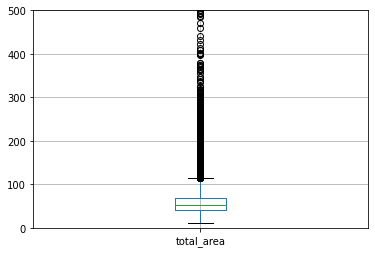

In [25]:
data.boxplot(column=['total_area'])

plt.ylim(0,500)
data['total_area'].describe()

С нижней границей все ок, нет нулевой площади, начинается c 12м2. А вот максимальная площадь имеет много выбросов. Верхний ус на 110, далее выбросы. Причем, начиная примерно с 300 их становится все меньше (отдельные точки, не сплошная линия). Посмотрим только эти строки.

In [26]:
data.query('total_area > 300')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
155,8,96000000.0,317.0,2017-07-07,4,3.50,3.0,183.0,3,False,...,NaN,1,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
581,20,65000000.0,365.0,2019-03-18,7,2.90,7.0,NaN,7,False,...,NaN,0,Санкт-Петербург,19827.0,1690.0,3.0,378.0,3.0,58.0,NaN
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,False,...,26.4,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
793,20,135000000.0,310.0,2018-05-22,4,3.30,5.0,250.0,2,False,...,50.0,0,Санкт-Петербург,34159.0,7251.0,2.0,295.0,3.0,190.0,342.0
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,False,...,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20820,7,73900000.0,342.0,2015-06-18,5,NaN,4.0,187.0,2,False,...,10.0,0,Санкт-Петербург,25079.0,5544.0,0.0,NaN,1.0,251.0,377.0
21955,19,130000000.0,431.0,2017-10-02,7,3.70,8.0,220.0,5,False,...,20.0,5,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,161.0
21990,20,68000000.0,373.1,2018-09-08,8,NaN,8.0,176.2,8,False,...,29.4,0,Санкт-Петербург,37965.0,7873.0,1.0,562.0,3.0,691.0,234.0
22131,14,27000000.0,422.2,2018-10-18,5,2.70,13.0,NaN,11,False,...,NaN,0,Санкт-Петербург,46625.0,16554.0,0.0,NaN,0.0,NaN,NaN


Судя по цене и количеству комнат, такая площадь вполне может быть. Для того, чтобы точно удостовериться, выберем строки с площадью выше 300 и ценой меньше 20 млн.руб.

In [27]:
data.query('total_area > 300 and last_price < 20000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11087,3,14000000.0,320.0,2017-09-27,6,NaN,3.0,190.0,3,False,...,28.0,0,Красное Село,26020.0,29445.0,1.0,569.0,0.0,NaN,8.0
13397,14,19500000.0,309.7,2016-02-03,9,NaN,5.0,199.0,5,False,...,14.3,0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0


Таких строк всего 2 и в них тоже вполне реалистичные данные.

По следующим столбцам сделаем диаграммы размаха и описание (в первую очередь для понимания крайних значений):

**'rooms'**

count    23649.000000
mean         2.070109
std          1.078643
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

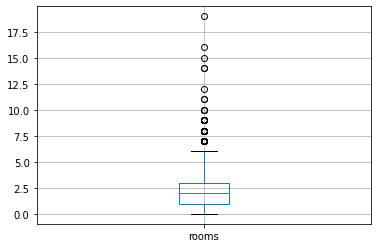

In [28]:
data.boxplot(column=['rooms'])
data['rooms'].describe()

Есть отдельные редкие высокие значения, максимальное количество комнат - 19. Такое допустимо.

**'ceiling_height'**

count    14489.000000
mean         2.771289
std          1.261637
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

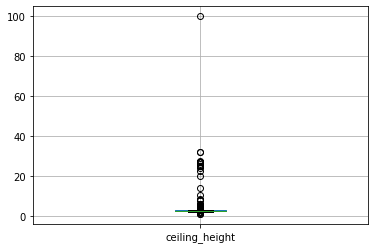

In [29]:
data.boxplot(column=['ceiling_height'])

data['ceiling_height'].describe()

Из диаграммы видно, что есть неадекватные высокие значения, в них явно ошибка. Кроме этого минимальное значение в описании указано 1, это также нужно проверить.

In [30]:
data.query('ceiling_height < 1.5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14,2,1.2,2.0,27.5,1,False,...,5.2,0,поселок городского типа Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
22590,16,6000000.0,55.0,2018-10-31,2,1.0,12.0,32.4,7,False,...,10.0,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


Потолок высотой 1,2 м2 может быть в полуподвальном помещении, на это указывает как раз 1 этаж. Это значение оставляем. А вот потолок в 1 м2 на 7-м этаже многоэтажки с указанием цены в 6 млн.руб. - явная ошибка. Данную строку из исследований удалим.

In [31]:
data = data[data['ceiling_height']!=1.0]

Теперь проверим высокие потолки:

In [32]:
data.query('ceiling_height> 10.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,False,...,8.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,False,...,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,False,...,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,5.5,0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,False,...,9.0,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,False,...,7.0,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,False,...,12.0,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3300000.0,44.4,2019-03-25,2,25.0,5.0,31.3,5,False,...,5.7,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000.0,42.0,2017-03-26,3,25.0,5.0,30.0,2,False,...,5.2,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


Здесь явная ошибка, скорее всего указан неправильный порядок. Разделим эти значения на 10. Условие выставим >11, так как есть строка с высотой 10,3 м2, делить значение это на 10 не логично.

In [33]:
data.loc[data['ceiling_height']>11.0, 'ceiling_height'] = (
data.loc[data['ceiling_height']>11.0, 'ceiling_height']/10
)
data.query('ceiling_height> 10.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16.0,15.5,15,False,...,NaN,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0


 Осталась только одна строка, которую не будем менять.

**'floors_total'**

count    23563.000000
mean        10.675211
std          6.594437
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

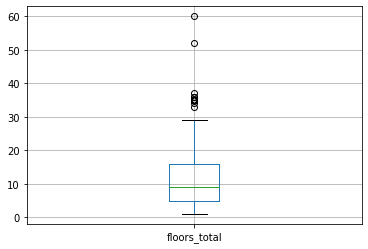

In [34]:
data.boxplot(column=['floors_total'])

data['floors_total'].describe()

Нет нулевых значений, минимальное значение - 1. Максимальное - 60 этажей. В СПб Лахта-центр (самое высокое здание) имеет 88 этажей, возможно в этом здании продается недвижимость (коммерческая). Здесь все ок.

**'balcony'**

Здесь достаточно оценить мин. и макс. значения на адекватность.

In [35]:
data['balcony'].describe()

count    23648.000000
mean         0.591763
std          0.959687
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

Есть еще несколько условий, которые должны выполняться и мы можем это проверить:
-  'living_area' < 'total_area'            
-  'kitchen_area' < 'total_area'
- 'floor' <= 'floors_total'

In [36]:
data.query(('living_area >total_area') or ('kitchen_area > total_area') or ('floor > floors_total'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Проведен анализ на выявление и исправление аномальных значений.

По результатам удалено аномальное значение в цене объекта (нелогично низкая цена 12190 руб.), а также объект с высотой потолка 1м в многоэтажном доме на 7-м этаже.

Кроме этого обнаружены ошибочно указанные данные в столбце "высота потолка" (указан неправильный порядок), данные исправлены.

Проверен ряд условий на соответствие: 
- жилая площадь и кухня не более общей площади объекта;
- указанный этаж не более общего количества этажей.

Все условия выполняются верно.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу новые столбцы:
- цена за 1 кв.м.;
- день недели публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа;
- расстояние до центра города в километрах.

In [37]:
#цена за 1 кв.м (используемые в расчете столбцы не имеют пропусков, 'total_area' не имеет значений 0)
data['price_meter'] = (data['last_price']/data['total_area']).round(2)

#день недели
data['weekday'] = data['first_day_exposition'].dt.weekday

#месяц и год публикации
data['month'] = data['first_day_exposition'].dt.month

data['year'] = data['first_day_exposition'].dt.year

#выведем на экран новую таблицу, проверим новые столбцы
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018


In [38]:
#напишем функцию для определения типа этажа

def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(floor_type,axis=1)

#проверим значения в новом столбце
data['floor_type'].value_counts()

другой       17407
последний     3329
первый        2912
Name: floor_type, dtype: int64

In [39]:
#переведем расстояние до центра в км и округлим
data['cityCenters_km'] = (data['cityCenters_nearest']/1000).round()

#выведем еще раз на экран таблицу, проверим новые столбцы
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,month,year,floor_type,cityCenters_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

#### Исследование параметров объекта

**'area'** 

Построим гистограммы для общей площади, жилой площади и кухни.

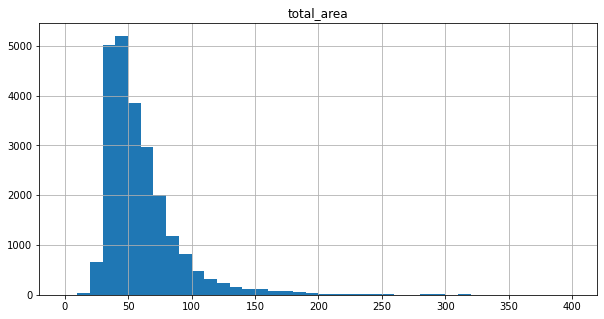

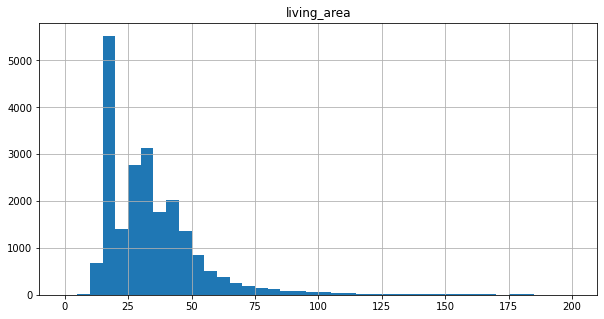

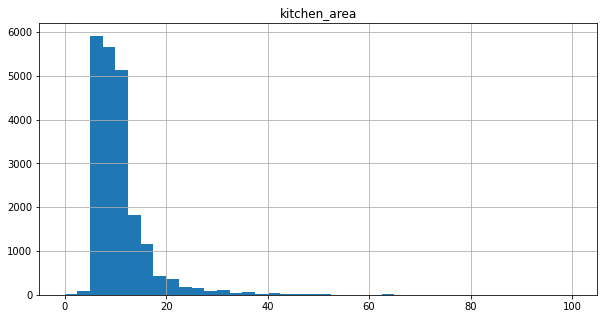

In [40]:
data['total_area'].hist(bins=40, range=(0, 400),figsize=(10,5),grid=True)
plt.title('total_area')
plt.show()

data['living_area'].hist(bins=40, range=(0, 200),figsize=(10,5),grid=True)
plt.title('living_area')
plt.show()

data['kitchen_area'].hist(bins=40, range=(0, 100),figsize=(10,5),grid=True)
plt.title('kitchen_area')
plt.show()

Из графика видно, что около 50% от всех объявлений - это квартиры общей площадью 30-50 кв.м, далее плавный спад - с увеличением площади квартиры, количество предложений уменьшается. Также малая доля (не более 10%) квартир с небольшой площадью 10 кв.м.

Логично, если гистограмма жилой площади имела бы такую же форму как и общая, однако здесь можно заметить пик на меленькой площади (15 м2) - это около 23% предложений (возможно это коммерческая недвижимость с жилой частью). И далее 25-30м2 также большая часть объявлений (а это составляет примерно 50% от самой популярной общей площади).

БОльшая доля (70%) это небольшие кухни площадью 5-12 м2.

**'last_price'** 

Теперь вернемся к цене квартиры. Для удобства используем базу с ценой, разделенной на 1млн. Такую переменную мы создавали - data_info.

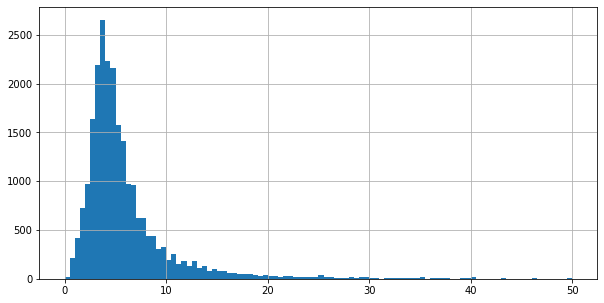

In [59]:
data_info.hist(bins=100, range=(0, 50),figsize=(10,5),grid=True)
plt.show()

График напоминает колокол, распределение нормальное. Наиболее популярная цена (около 12%) в районе 4 млн.руб.

**'rooms','ceiling_height'**

Следующий блок гистограмм для проверки и анализа:
- количество комнат;
- высота потолков.

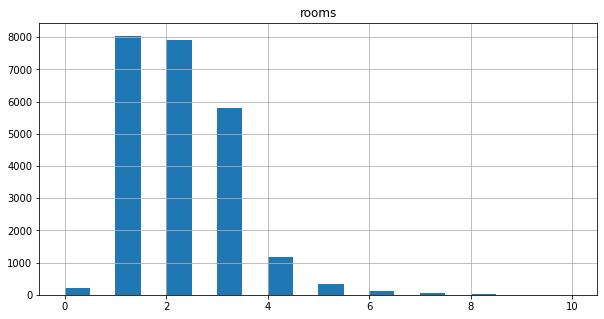

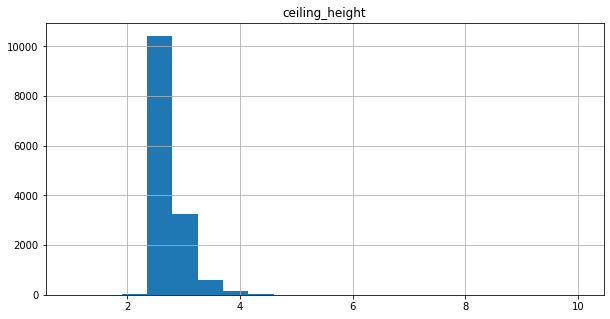

In [42]:
data['rooms'].hist(bins=20,range=(0, 10),figsize=(10,5),grid=True)
plt.title('rooms') 
plt.show()

data['ceiling_height'].hist(bins=20,range=(1, 10),figsize=(10,5),grid=True)
plt.title('ceiling_height')
plt.show()

Большинство объявлений - это 1-, 2-хкомнатные квартиры.

Основное количество предложений с высотой потолков в пределах 2-4 м, около 50% всех предложений - 2,5 метров, что соответствует стандартной высоте в квартирах.

**'floor'**

Более подробно изучим этажность в объявлениях - этаж квартиры и общую этажность в доме.

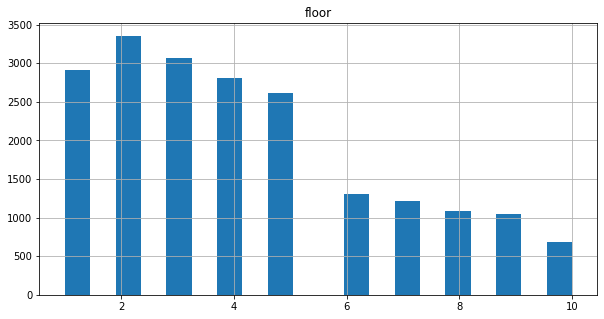

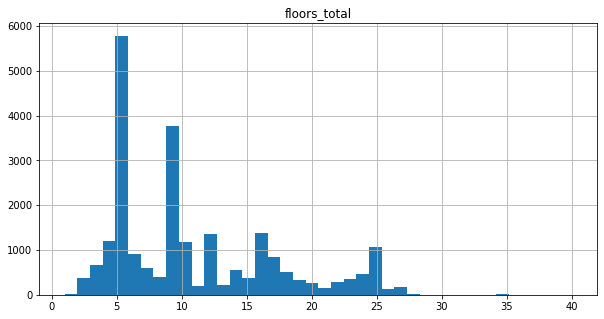

In [43]:
data['floor'].describe() #посмотрим как ограничить диапазон
data['floor'].hist(bins=20,range=(1, 10),figsize=(10,5),grid=True)
plt.title('floor') 
plt.show()

data['floors_total'].hist(bins=40,range=(1, 40),figsize=(10,5),grid=True)
plt.title('floors_total') 
plt.show()

Самые популярные этажи в квартирах на продажу - это с 1 по 5,при этом 2 и 3 - пик, 1;4 и 5 чуть меньше. При этом больше всего предложений в 5-тиэтажках (около 25%) и в 9-тиэтажках - 15%.

Так как 5 этаж в объявлении наиболее часто встречается и больше всего предложений в 5-тиэтажках, логично предположить, что предлагаются на продажу в большой доле последние этажи. Проверим эту гипотезу через анализ типа этажа.

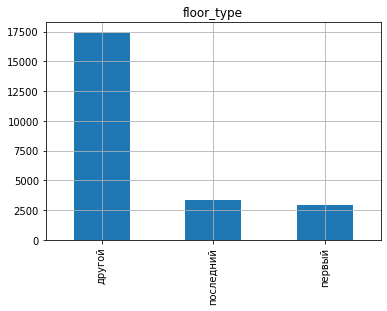

In [44]:
data['floor_type'].value_counts().plot(kind='bar',grid=True)
plt.title('floor_type')
plt.show()

Примерно в равной доле предлагаются первый и последний этажи (примерно по 10-12%).

**'__nearest'**

Следующий блок исследования - картографическое расположение:
- расстояние до центра города;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- расстояние до ближайшего водоема.

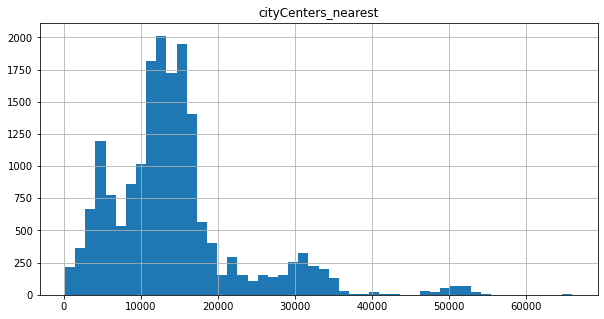

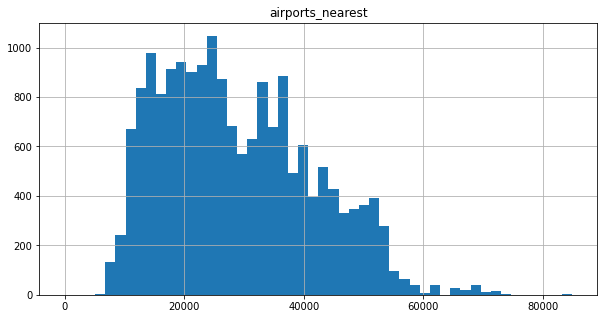

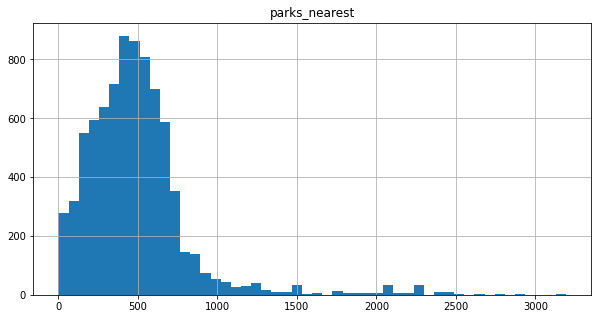

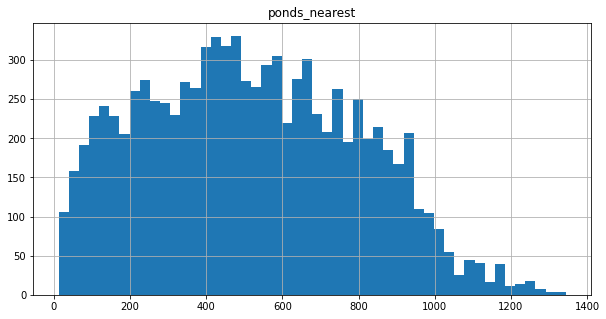

In [45]:
data['cityCenters_nearest'].hist(bins=50,figsize=(10,5),grid=True)
plt.title('cityCenters_nearest') 
plt.show()

data['airports_nearest'].hist(bins=50,figsize=(10,5),grid=True)
plt.title('airports_nearest') 
plt.show()

data['parks_nearest'].hist(bins=50,figsize=(10,5),grid=True)
plt.title('parks_nearest') 
plt.show()

data['ponds_nearest'].hist(bins=50,figsize=(10,5),grid=True)
plt.title('ponds_nearest')
plt.show()

Можно сделать вывод, что большинство объектов располагается в радиусе 10-20 км от центра. Объекты, для которых указано расстояние до аэропорта - большинство располагается на расстоянии 15-25 км. Эти значения коррелируются и это логично, так как аэропорт в СПб находится всего в 15 км от города.
Если оценивать гистограммы по расстоянию до парков и водоемов, с первого взгляда можно отметить, что у большинства есть в радиусе 1 км парк/водоем. Однако, отметим, что в данных столбцах заполнено только около 35% строк, поэтому данная гипотеза не обоснована.

**'weekday','month'**

Построим гистограмму по дате размещения объявлений.

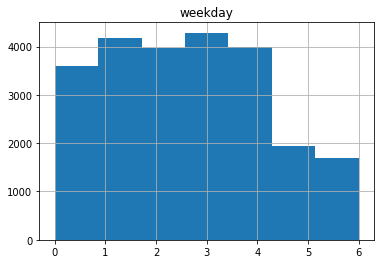

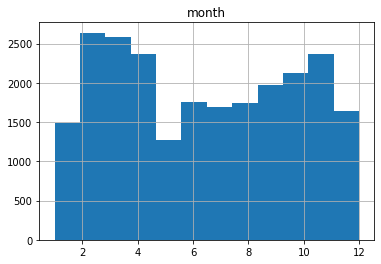

In [46]:
data['weekday'].hist(bins=7,grid=True)
plt.title('weekday')
plt.show()

data['month'].hist(bins=12,grid=True)
plt.title('month')
plt.show()

Можно сделать следующие выводы - в будни объявления публикуются чаще, чем в выходные. Самые популярные дни для размещения - вторник и четверг.

Что касается сезонности, то можно отметить, что объявлений больше разместили в весенне-осенний периоды. Меньше всего объявления размещают в январе и мае, скорей всего это связано с длинными праздничными выходными.

#### Исследование количества дней размещения объявления
Теперь проанализируем сам процесс продажи. Начнем с количества дней, которое объявление было размещено.

count    20468.000000
mean       180.769836
std        219.782208
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


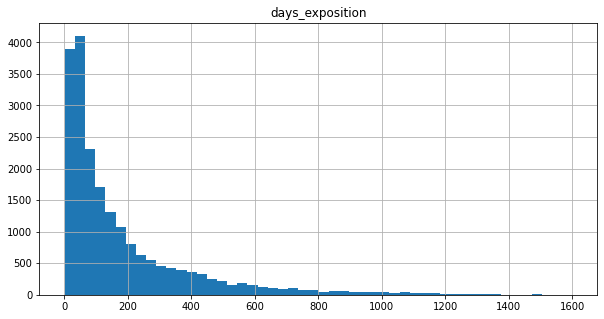

In [47]:
print(data['days_exposition'].describe())

data['days_exposition'].hist(bins=50,range=(1,1600),figsize=(10,5),grid=True)
plt.title('days_exposition')
plt.show()

Медиана (180 дней) и среднее (95 дней) отличаются почти в 2 раза, значит есть выбросы, но не похоже, чтобы такую разницу дали редкие высокие значения, посмотрим на распределение в диапазоне от 1 до 200.

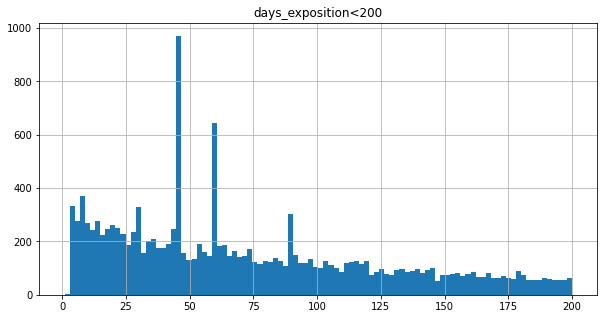

In [48]:
data['days_exposition'].hist(bins=100,range=(1,200),figsize=(10,5),grid=True)
plt.title('days_exposition<200')
plt.show()

Есть выбивающиеся значения в 45 и 60 дней, далее чуть меньше пик в 90 дней, такие круглые сроки очень похожи на установленные на платформах сроки размещения объявлений, после которых они автоматически снимаются. Необходимо уточнить этот момент у владельцев данных и если гипотеза подтвердиться убрать из выборки эти данные для количества дней продажи.

В текущей ситуации можно отнести к быстрым продажам сроки до 45 дней, к нормальным - медианное 95 дней, а к необычно долгим свыше 2-х лет.

#### Факторы, влияющие на общую стоимость 
Рассмотрим зависимости цены от разных параметров:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- типа этажа;
- даты размещения (день недели, месяц, год).

0.6537865141918754


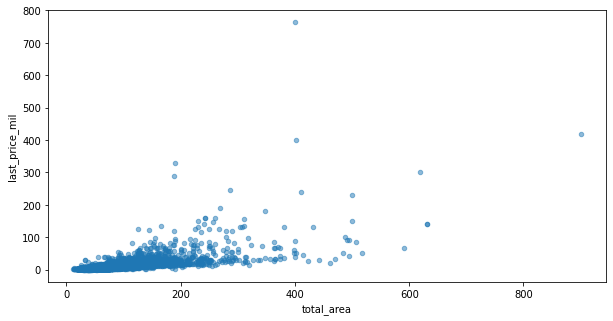

0.5665658036784887


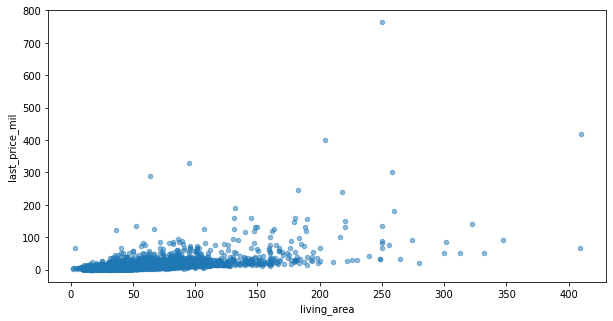

0.5203799972091142

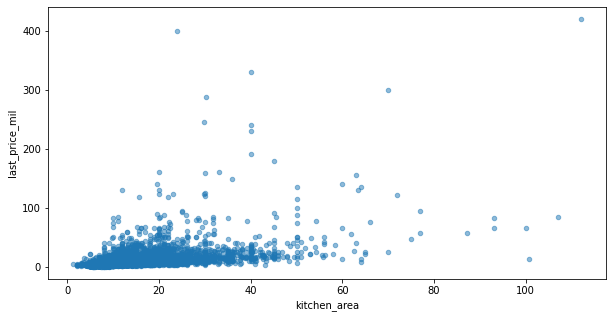

In [49]:
#добавим в таблицу столбец с ценой в млн.руб. для удобства построения графиков
data['last_price_mil'] = (data['last_price']/1000000).round()

data.plot(x='total_area', y='last_price_mil',kind='scatter', figsize=(10,5),alpha=0.5)
print(data['total_area'].corr(data['last_price_mil']))
plt.show()

data.plot(x='living_area', y='last_price_mil',kind='scatter', figsize=(10,5),alpha=0.5)
print(data['living_area'].corr(data['last_price_mil']))
plt.show()

data.plot(x='kitchen_area', y='last_price_mil',kind='scatter', figsize=(10,5),alpha=0.5)
data['kitchen_area'].corr(data['last_price_mil'])

Зависимость есть и достаточно высокая - чем больше площадь, тем выше цена. При этом наибольшая зависимость от общей площади - к-т 0,65, наименьшая от площади кухни - 0,52.

Посмотрим как влияет количество комнат и тип этажа на общую цену.

0.363483548528431

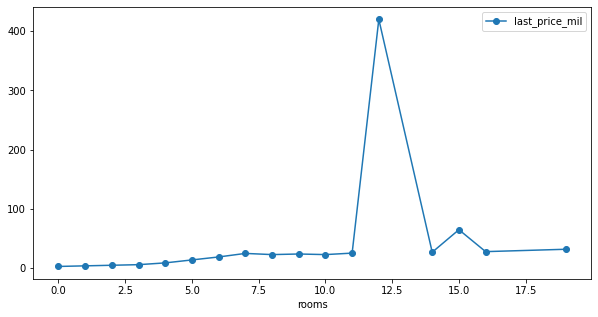

In [50]:
data_pivot_rooms = data.pivot_table(index='rooms',values='last_price_mil',aggfunc='median')
data_pivot_rooms.plot(style = 'o-',figsize=(10,5))

data['rooms'].corr(data['last_price_mil'])

Есть 1 пик на 12 комнатах, но это говорит только о том, что скорее всего есть одно или несколько предложений по высокой цене, поэтому дало такой результат. В остальном зависимость небольшая, что подтверждает коэффициент корреляции 0,36.

In [51]:
data.query('rooms==12')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday,month,year,floor_type,cityCenters_km,last_price_mil
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,False,...,2.0,318.0,106.0,466666.67,2,12,2017,последний,8.0,420.0


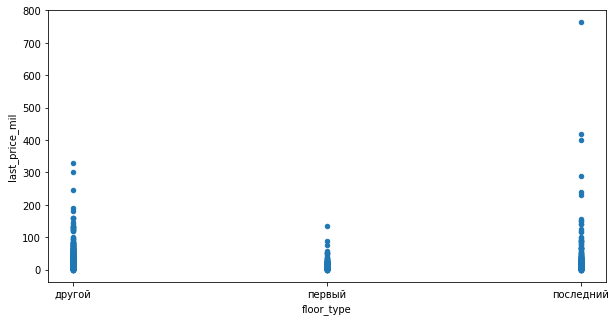

In [60]:
#посмотрим сначала по общим данным
data.plot(x='floor_type', y='last_price_mil',kind='scatter', figsize=(10,5))
plt.show()

Квартиры на первом этаже пользуются наименьшим спросом.

Также из графика кажется, что последний этаж продается также как и категория"другие", но логика подсказывает, что это не так). Построим график по медианным значениям.

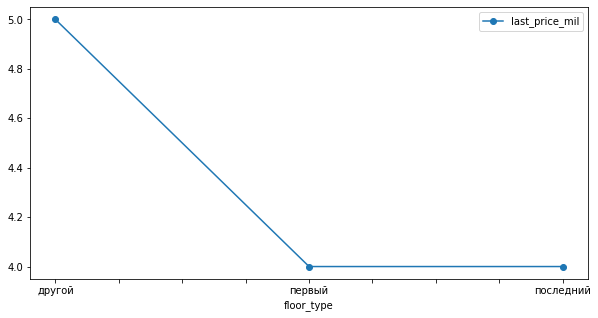

In [61]:
data_pivot_floor = data.pivot_table(index='floor_type',values='last_price_mil',aggfunc='median')
data_pivot_floor.plot(style = 'o-',figsize=(10,5))
plt.show()

Вот это больше похоже на правду. Первый и последний этажи по стоимости ниже, чем остальные, при этом их стоимость идентична.

И, наконец, посмотрим влияние даты размещения на цену.

         last_price_mil
weekday                
0              6.513311
1              6.393054
2              6.626640
3              6.706020
4              6.368487
5              6.986549
6              6.248818


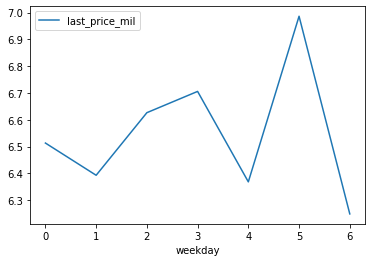

       last_price_mil
month                
1            6.660630
2            6.462675
3            6.366525
4            6.737885
5            6.594488
6            6.301425
7            6.644379
8            6.353042
9            6.825670
10           6.250589
11           6.467681
12           6.999389


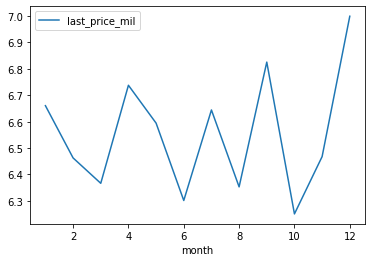

      last_price_mil
year                
2014       12.036765
2015        8.581415
2016        6.831465
2017        6.590226
2018        5.950652
2019        6.779013


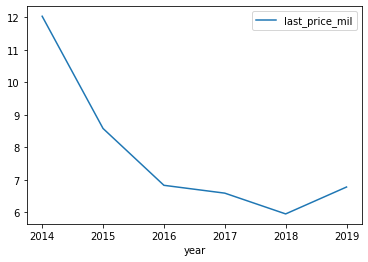

In [54]:
data_pivot_weekday = data.pivot_table(index='weekday',values='last_price_mil')
print(data_pivot_weekday)
data_pivot_weekday.plot()
plt.show()

data_pivot_month = data.pivot_table(index='month',values='last_price_mil')
print(data_pivot_month)
data_pivot_month.plot()
plt.show()

data_pivot_year = data.pivot_table(index='year',values='last_price_mil')
print(data_pivot_year)
data_pivot_year.plot()
plt.show()

Данные получились неоднозначные.

**День недели** - наблюдаем, что самая низкая цена в воскресенье, а самая высокая в субботу. Скорее всего, зависимости стоимости от дня недели размещения нет, перепады в цене связаны с количеством объявлений, ранее мы выяснили, что в выходные количество размещений меньше.

**Месяц** - как мы выяснили ранее сезонность на рынке присутствует. Из графика по общей цене сложно сделать вывод о зависимости общей цены от месяца размещения, более правильно будет сформировать график по цене за кв.м. 

Что касается **года размещения**, то можно отметить снижение средней стоимости объектов с 2014 по 2018 г., далее заметна тенденция к росту.

         price_meter
month               
1       99838.433870
2       98769.773335
3       99036.151453
4      101956.699558
5       98536.263039
6       97789.346689
7       99650.840734
8      100147.231975
9      100490.822592
10      97963.887923
11      99254.440803
12      99501.624628


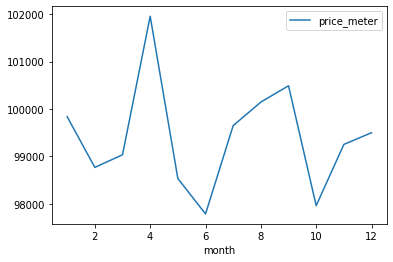

In [55]:
#сформируем график зависимости цены за кв.м. от месяца размещения, чтобы выявить сезонность

data_pivot_month = data.pivot_table(index='month',values='price_meter')
print(data_pivot_month)
data_pivot_month.plot()
plt.show()

На данном графике можно отметить сезонность в ценах за кв.м. Самые низкие цены в июне и октябре.

#### Средняя цена за кв.м. в топ-10 населенных пунктах

In [56]:
#сделаем сводную таблицу по населенным пунктам с количеством объявлений и средней ценой за кв.м.

data_pivot_top = (
data.pivot_table(index='locality_name',values='price_meter',
aggfunc=['count','mean']).round()
)

data_pivot_top.columns=['count','mean']

#сформируем то-10 населенных пунктов с самым большим количеством объявлений,
#запишем в переменную, чтобы дальше отсортировать по средней цене

data_pivot_top10 = data_pivot_top.sort_values('count',ascending=False).head(10)

data_pivot_top10.sort_values('mean',ascending=False)

,count,mean
locality_name,,
Санкт-Петербург,15719,114857.0
Пушкин,369,103126.0
деревня Кудрово,299,92474.0
поселок Парголово,327,90176.0
поселок Мурино,556,85682.0
поселок Шушары,440,78677.0
Колпино,338,75425.0
Гатчина,307,68746.0
Всеволожск,398,68654.0


Таким образом, среди 10 населенных пунктов с самым большим количеством объявлений самая высокая цена за кв.м.в Санкт-Петербурге - 114857 руб., а самая низкая в Выборге - 58142 руб.

#### Средняя цена за км до центра

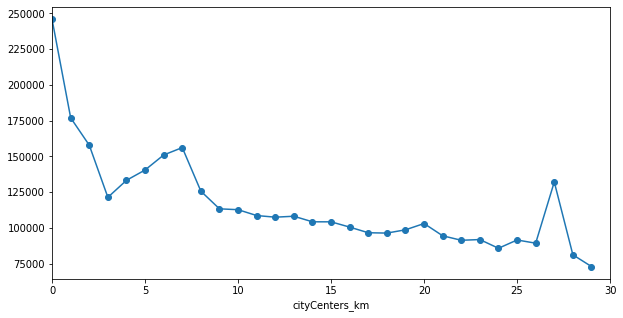

In [57]:
data_final = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_km',
values='price_meter',aggfunc=['count','mean'])

data_final.columns = ['count','mean']

data_final['mean'].plot(style='o-', xlim=(0,30),figsize=(10,5))
plt.show()

In [58]:
#виден резкий скачок на 27 км, посмотрим в сводной с чем связано.
data_final.tail()

,count,mean
cityCenters_km,,
25.0,26,91531.371154
26.0,53,89285.877170
27.0,2,132115.710000
28.0,7,81161.914286
29.0,6,72953.365000


Вывод вполне логичен - чем дальше квартира от центра, тем стоимость за кв.м меньше. При этом сначала идет резкий спад цены, а далее более плавный. Резкий скачок на 27 км связан с предложением 2-х квартир по высокой цене, это скорее исключение из общей тенденции.

По графику хорошо видно, что до 3 км сильно падает цена, но поскольку дальше все-таки есть небольшой подъем и 3 км это для рынка недвижимости большого города очень маленькое ограничение, я бы ограничила 8-10 км.

### Общий вывод

**Цель данного проекта** – провести исследовательский анализ данных и найти зависимости, которые существуют на рынке недвижимости.

**Входные данные** — данные сервиса Яндекс Недвижимость — архив объявлений за 2014-2019 гг. о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

В процессе обработки исходных данных были заполнены пропуски, где возможно, а также определены причины этих пропусков. Так, пропуски в столбце с количеством балконов, скорее всего, связаны с их отсутствием. Пропуски в картографических данных связаны с отсутствием данных о точном адресе недвижимости. Можно ввести в данные столбцы обязательное требование к заполнению.
Были выявлены и исключены аномальные значения, устранены неявные дубликаты в наименованиях населенных пунктов.

Добавлены новые столбцы для дальнейшего исследования: цена за кв.м., расстояние до центра в км, тип этажа (первый, последний, другой), дата размещения объявления в разрезе день недели, месяц, год.

**Задачи дальнейшего исследования данных:**

    1.Определить какие параметры влияют на количество размещенных объявлений 
    2.Определить сколько дней было в среднем размещены объявления (за какой срок продаются квартиры) 
    3.Определить какие параметры влияют на общую цену и цену квадратного метра

По результатам исследования и анализа сделаны следующие **выводы:**

**1.	Количество:**

Наибольшее количество объявлений отличаются следующими параметрами:
- больше всего предложений в Санкт-Петербурге, 
- чаще всего предлагают недвижимость общей площадью 30-50 кв. м.,
- больше всего объявлений с ценой до 10 млн. руб. Наиболее популярная цена в районе 4-5 млн. руб.,
- наибольшее количество предложений – это 1-, 2-комнатные квартиры,
- предложения чаще всего в 5-ти и 9-тиэтажках,
- в общей выборке чаще встречаются квартиры, расположенные с 1 по 5 этаж. Примерно в - равной доле предлагаются первый и последний этажи (примерно по 10-12%),
- интересна закономерность, что самые популярные дни для размещения - вторник и четверг. И, естественно, что в будни объявления размещают чаще, чем в выходные,
- также отмечена сезонность в количестве размещенных объявлений, больше разместили в весенне-осенний периоды. Меньше всего объявления размещают в январе и мае, скорей всего это связано с длинными праздничными выходными.

**2. Срок продажи:**

По результатам анализа к быстрым продажам можно отнести продажи в сроки до 45 дней, к нормальным - 95 дней, а к необычно долгим свыше 2-х лет. Однако, здесь следует отметить, что в выборку попали объявления, которые, скорее всего, автоматически были сняты системой через 45 и 60 дней. Необходимо уточнить этот момент у владельцев данных и исключить из выборки такие данные, тогда средние сроки могут измениться.

**3. Общая цена и цена за кв.м.**

На общую стоимость квартиры существенно влияет площадь квартиры, этаж (не первый и не последний), количество комнат влияет не существенно. Также отмечено, что в июне и октябре цена предложения ниже, думаю, это связано со снижением спроса в этот период и сезонностью на рынке недвижимости.

Цена за кв. м прямо зависит от удаленности от центра. Самая высокая цена за кв. м в Санкт-Петербурге и составляет в среднем 114857 руб. (данные по объявлениям за весь период 2014-2019)